### THIS IS A FIRST GLIMPSE OF THE DATA FOR THE PROJECT WIKISPEEDIA

Import Libraries 

In [2]:
import pandas as pd
import tarfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import requests
from bs4 import BeautifulSoup 
import os

DOWNLOAD THE DATA FROM PYTHON SCRIPT

In [3]:
directory_path = "./data"

# Vérifiez si le répertoire existe déjà
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print("Répertoire data créé")
else:
    print("Le répertoire data existe déjà.")


urls=["https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz",
      "https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_plaintext.tar.gz"]
      #,"https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_html.tar.gz"]
      #Le dernier lien contient tous les codes htm de tous les articles wikispeedia (très lourd et jsp si on va utiliser ?)

for url in urls:    
    response=requests.get(url)
    if response.status_code==200: #Verify that the response is True
        save_path="./data/"+url[43:]
        with open(save_path,"wb")as f:
            f.write(response.content)
            print(save_path+" downloaded")

PATH=["./data/wikispeedia_paths-and-graph.tar.gz",
    "./data/wikispeedia_articles_plaintext.tar.gz"]

DEST=["./data/wikispeedia_paths-and-graph",
      "./data/wikispeedia_articles_plaintext"]

for i,path in enumerate(PATH):
    with tarfile.open(path,"r:gz") as fichier:
        fichiers_names=fichier.getnames()
        for name in fichiers_names:
            fichier.extract(name, DEST[i])
        
for path in PATH:
    os.remove(path)

Le répertoire data existe déjà.
./data/wikispeedia_paths-and-graph.tar.gz downloaded
./data/wikispeedia_articles_plaintext.tar.gz downloaded


Utilisation des données sur les finished paths

In [4]:
PATH="./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"


finished_path=pd.read_csv(PATH, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
finished_path.head()
unfinished_path.head()
print(f"Finished paths : First date {finished_path.timestamp.dt.date.min()} \t Last Date {finished_path.timestamp.dt.date.max()} ")
print(f"Unfinished paths : First date {unfinished_path.timestamp.dt.date.min()} \t Last Date {unfinished_path.timestamp.dt.date.max()} ")


Finished paths : First date 2008-08-18 	 Last Date 2014-01-15 
Unfinished paths : First date 2011-02-07 	 Last Date 2014-01-15 


,hashedIpAddress,timestamp,durationInSec,path_start,path_goal,rating
0,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
1,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
2,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
3,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
4,131600803df4895e,2011-02-07 17:42:37,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout


                            Name  Count
0  Actors_models_and_celebrities     25
1                        Artists     36
2     Astronomers_and_physicists     21
3                       Chemists      8
4               Computing_People      9


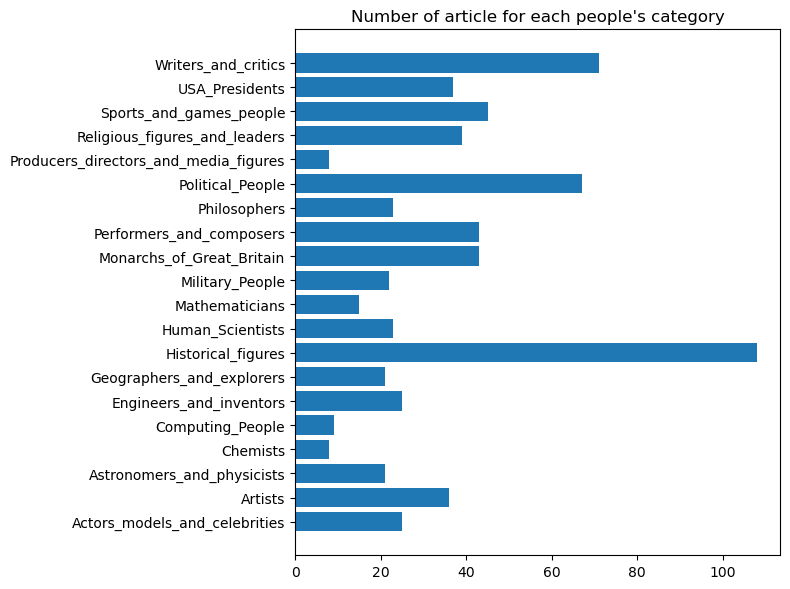

In [5]:
path = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/categories.tsv"

categories = pd.read_csv(path,header = 12, delimiter='\t',names=["article","categories"])
categories['article'] = categories['article'].apply(lambda x :(urllib.parse.unquote(x , encoding = 'utf-8'))) # Decode article names

people = categories[categories['categories'].str.contains('subject.People')].copy() # Dataset of people
people['categories'] = people['categories'].apply(lambda x : x[len('subject.People.'):]) # Remove useless string

#print(people.head())
#print(people.shape)
#print(people.categories.unique(),len(people.categories.unique()))
counts = people.groupby('categories').count()
counts = counts.reset_index()
counts.columns = ["Name", "Count"]
print(counts.head())

plt.figure(figsize=(8, 6))

plt.barh(counts["Name"], counts['Count'])
plt.title("Number of article for each people's category")
plt.xticks(rotation=0)
plt.tight_layout()

In [11]:
people["categorie"]

,article,categories
0,Áedán_mac_Gabráin,subject.People.Historical_figures
1,Åland,subject.Countries
2,Åland,subject.Geography.European_Geography.European_...
3,Édouard_Manet,subject.People.Artists
4,Éire,subject.Countries


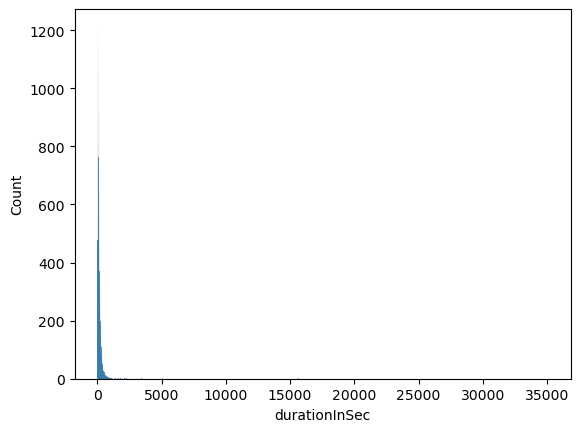

In [9]:
ax=sns.histplot(finished_path["durationInSec"], bins=10000)

Text(0, 0.5, 'Duration [s]')

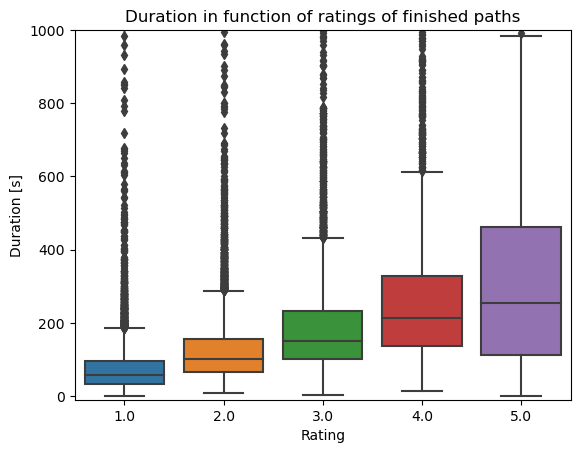

In [7]:

ax=sns.boxplot(x="rating", y="durationInSec", data=finished_path)
ax.set_ylim([-10,1000])
ax.set_title("Duration in function of ratings of finished paths")
ax.set_xlabel("Rating")
ax.set_ylabel("Duration [s]")


In [8]:
finished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


Chemin du trajet le plus long en temps: 91 pages


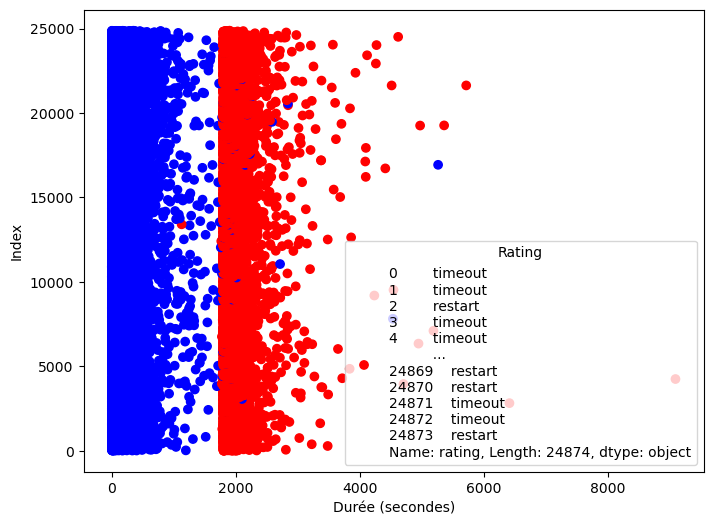

max duration for unfinished_path 151.48333333333332
max duration for finished_path 584.85


In [12]:
unfinished_path_duration = unfinished_path['durationInSec']
unfinished_path_rating = unfinished_path['rating']

max_duration_unfinished = max(unfinished_path_duration)
max_duration_finished = max(finished_path['durationInSec'])

max_duration_finished_id = finished_path.sort_values(by = 'durationInSec', ascending= False)
longest_trip = max_duration_finished_id.iloc[0]
print(f"Chemin du trajet le plus long en temps: {len(longest_trip['path'])} pages")


plt.figure(figsize=(8, 6))
colors = {'timeout': 'red', 'restart': 'blue'}
plt.scatter(unfinished_path_duration, range(len(unfinished_path)), c=[colors[r] for r in unfinished_path_rating], label=unfinished_path_rating)

plt.xlabel('Durée (secondes)')
plt.ylabel('Index')
plt.legend(title='Rating')

plt.show()

print('max duration for unfinished_path', max_duration_unfinished/60)
print('max duration for finished_path', max_duration_finished/60)


je vais essayer de stocker les pages des paths et de compter sur tous les finished path combien elles sont utilisées

In [13]:
finished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [39]:
# je concatenate tout en une seule chaine de caractère
all_paths_fin = ';'.join(finished_path['path']).split(';')

# je fabrique une liste en supprimant les doublons, je calculerais ensuite la fréquence la dessus
path_fin = list(set(all_paths_fin))


# pas très beau mais bon walla ça marche
path_fin_count = {}
for path in all_paths_fin:
    if path in path_fin_count:
        path_fin_count[path] += 1
    else:
        path_fin_count[path] = 1

path_fin_count
# je vais maintenant chercher les hubs

{'14th_century': 154,
 '15th_century': 187,
 '16th_century': 225,
 'Pacific_Ocean': 844,
 'Atlantic_Ocean': 1324,
 'Accra': 18,
 'Africa': 2796,
 'Atlantic_slave_trade': 105,
 'African_slave_trade': 31,
 'Europe': 4362,
 'Niger': 55,
 'Nigeria': 80,
 'British_Empire': 746,
 'Slavery': 206,
 'Renaissance': 383,
 'Ancient_Greece': 761,
 'Greece': 510,
 'Italy': 867,
 'Roman_Catholic_Church': 499,
 'HIV': 112,
 'Ronald_Reagan': 118,
 'President_of_the_United_States': 850,
 'John_F._Kennedy': 172,
 'North_America': 1884,
 'United_States': 8896,
 'China': 1126,
 'Gunpowder': 96,
 'Fire': 112,
 'Time': 187,
 'Isaac_Newton': 254,
 'Light': 307,
 'Color': 236,
 'Rainbow': 83,
 'Plato': 117,
 'Nature': 244,
 'Ultraviolet': 130,
 'Science': 1497,
 'Weather': 281,
 'Sunlight': 137,
 '<': 20561,
 'Sun': 932,
 'Earth%27s_atmosphere': 380,
 'Christianity': 1097,
 'Bible': 304,
 'God': 457,
 'Optical_fiber': 88,
 'Astronomy': 416,
 'Empiricism': 16,
 'Rain': 208,
 'Leonardo_da_Vinci': 179,
 'Water': 

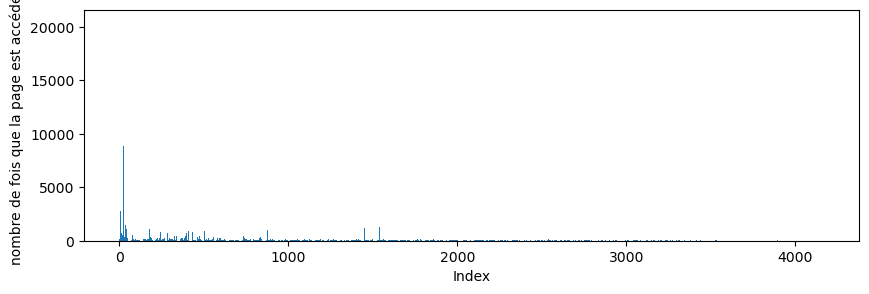

In [30]:
pages = list(path_fin_count.keys())
counts = list(path_fin_count.values())


plt.figure(figsize=(10, 3))
plt.bar(range(len(pages)), counts) 
plt.xlabel('Index')
plt.ylabel('nombre de fois que la page est accédée')
plt.show()

In [35]:
# maintenant, petit top 100 des pages 
# top 100 c'est trop grand --> top 25
top_100_fin_hubs = dict(sorted(path_fin_count.items(), key=lambda item: item[1], reverse=True)[:25])
top_100_fin_hubs

{'<': 20561,
 'United_States': 8896,
 'Europe': 4362,
 'United_Kingdom': 3904,
 'England': 3332,
 'Earth': 3223,
 'Africa': 2796,
 'World_War_II': 2301,
 'North_America': 1884,
 'Germany': 1769,
 'Animal': 1713,
 'Human': 1642,
 'Mammal': 1622,
 'France': 1617,
 'Computer': 1552,
 'Science': 1497,
 'English_language': 1430,
 'Periodic_table': 1413,
 'Atlantic_Ocean': 1324,
 'Brain': 1324,
 'Telephone': 1252,
 'India': 1236,
 'Bird': 1210,
 'Viking': 1198,
 'Agriculture': 1185}

Text(0.5, 1.0, 'Top 25 des pages les plus présentes dans les path')

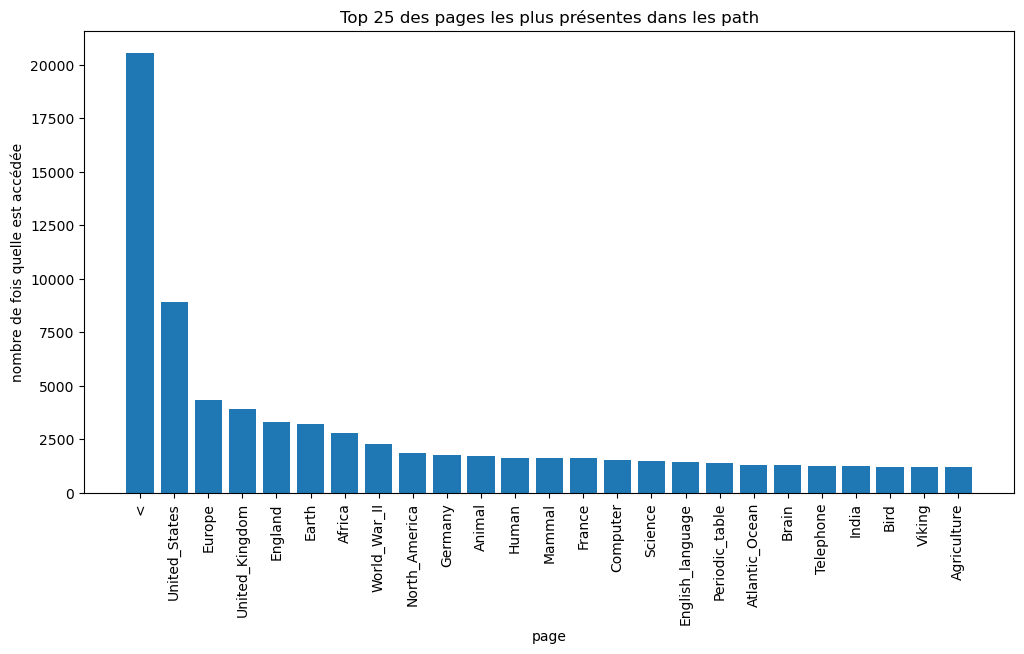

In [38]:
pages = list(top_100_fin_hubs.keys())
counts = list(top_100_fin_hubs.values())
# top 100 c'est trop grand --> top 25

plt.figure(figsize=(12, 6))
plt.bar(pages, counts) 
plt.xlabel('page')
plt.ylabel('nombre de fois quelle est accédée')
plt.xticks(rotation=90)
plt.title('Top 25 des pages les plus présentes dans les path')

marrant que la première page soit < ????? --> C'est lorsque l'utilisateur reviens sur la page précédente !


world war 2 est pas très loin dans le classement, on peut faire des recherches plus poussée pour les figures préférées de Wassim